# Set-Up

In [26]:
%run Set_Up.ipynb

# 4-step algorithm

In [2]:
%run algorithm_4_steps.ipynb

In [3]:
def step2(data, initial_days=7, expanding=True):    
    rates = pd.DataFrame(np.gradient(data, axis=0), index=data.index, columns=data.columns)
    if expanding:
        initial_rates = rates.expanding().mean()
    else:
        # TODO Find better solution for initial rates assignment
        initial_rates = pd.DataFrame(0, index=rates.index, columns=rates.columns)
        initial_rates += rates.iloc[:initial_days].mean()
    temp_mask = initial_rates[initial_days:] * 0.2 < rates[initial_days:] 
    min_k_mask = temp_mask.any(axis=1) 
    min_k = min_k_mask.idxmax()
    return min_k 

expd = False
min_k_1date = step2(data_1date_trunc, expanding=expd)
min_k_2date = step2(data_2date_trunc, expanding=expd)
min_k_5date = step2(data_5date_trunc, expanding=expd)
min_k_1day = step2(data_1day_trunc, expanding=expd)
min_k_1day = step2(data_2day_trunc, expanding=expd)
min_k_1day = step2(data_5day_trunc, expanding=expd)

## Plotting gradients of 8 countries

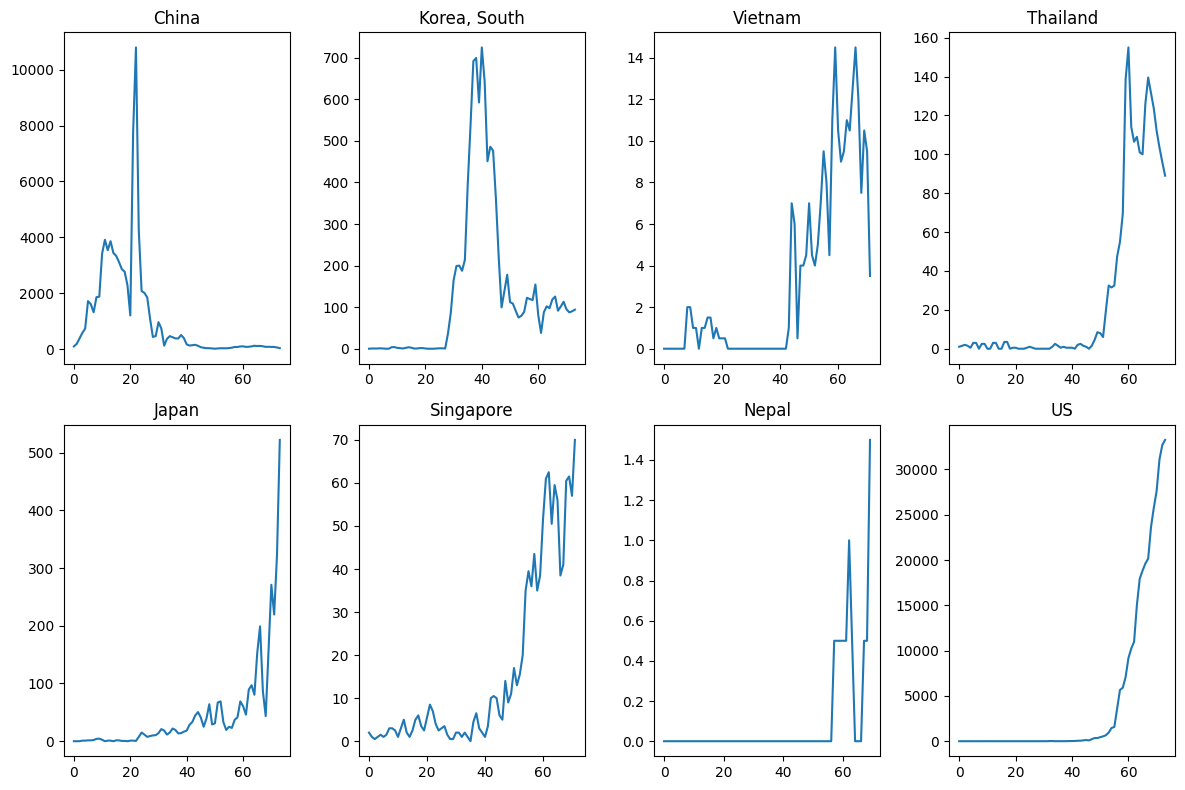

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

prova = data_1day[['China', 'Korea, South', 'Vietnam', 'Thailand', 'Japan', 'Singapore', 'Nepal', 'US']]
for i, country in enumerate(prova.columns):
    ax = axes.flat[i]
    ax.plot(np.gradient(data_1day[country]))
    ax.set_title(country)

# Show the plot
plt.tight_layout()
plt.show()


# Visualizations

## Plot Cases

### Absolute cases

#### Highest and oldest cases

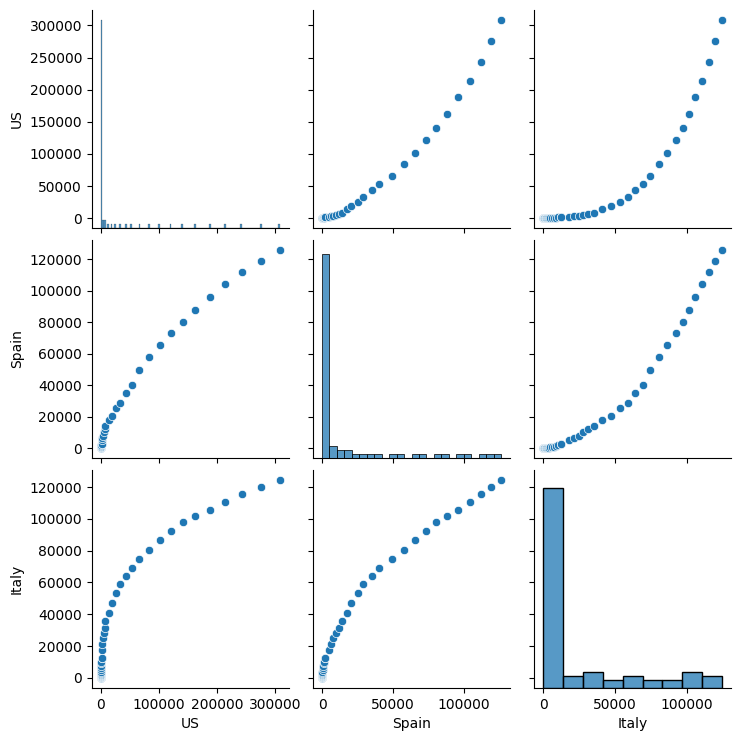

In [5]:
sns.pairplot(data_1date_trunc.iloc[:,:3]);

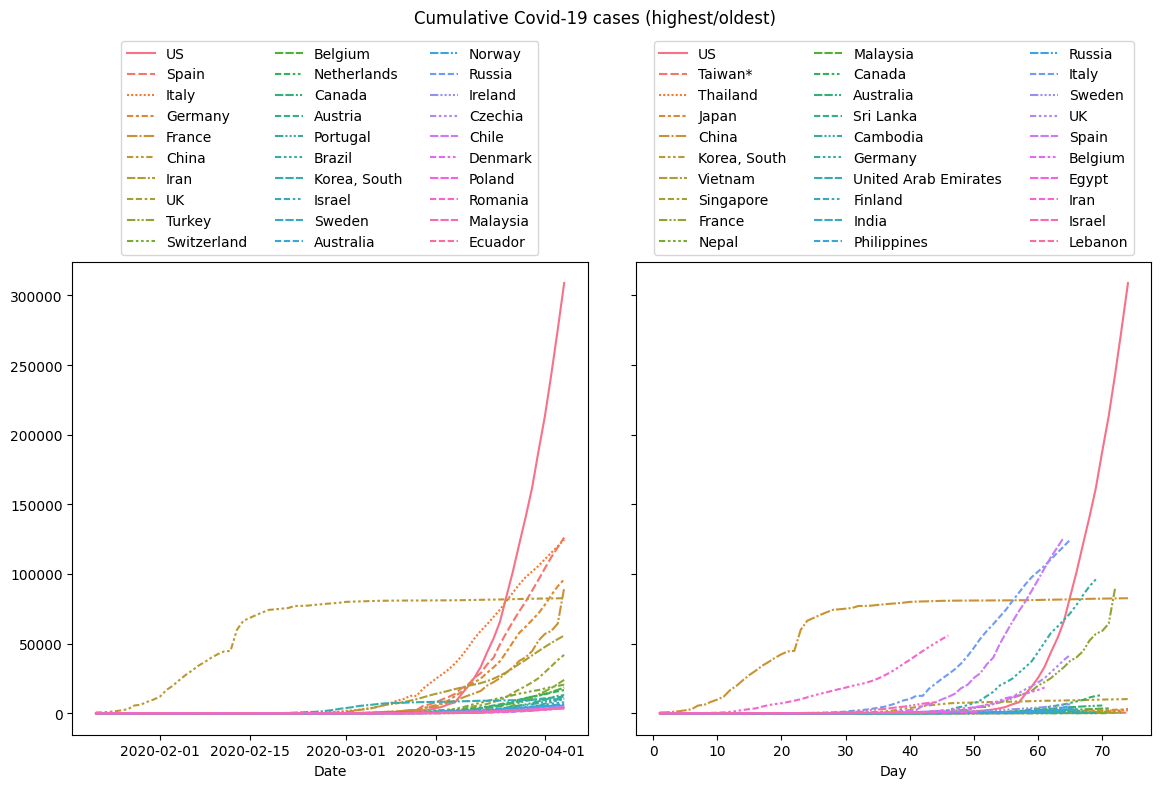

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

sns.lineplot(data=data_1date_trunc, ax=ax1)
sns.lineplot(data=data_1day_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig1_high.png')

#### Lowest and latest cases

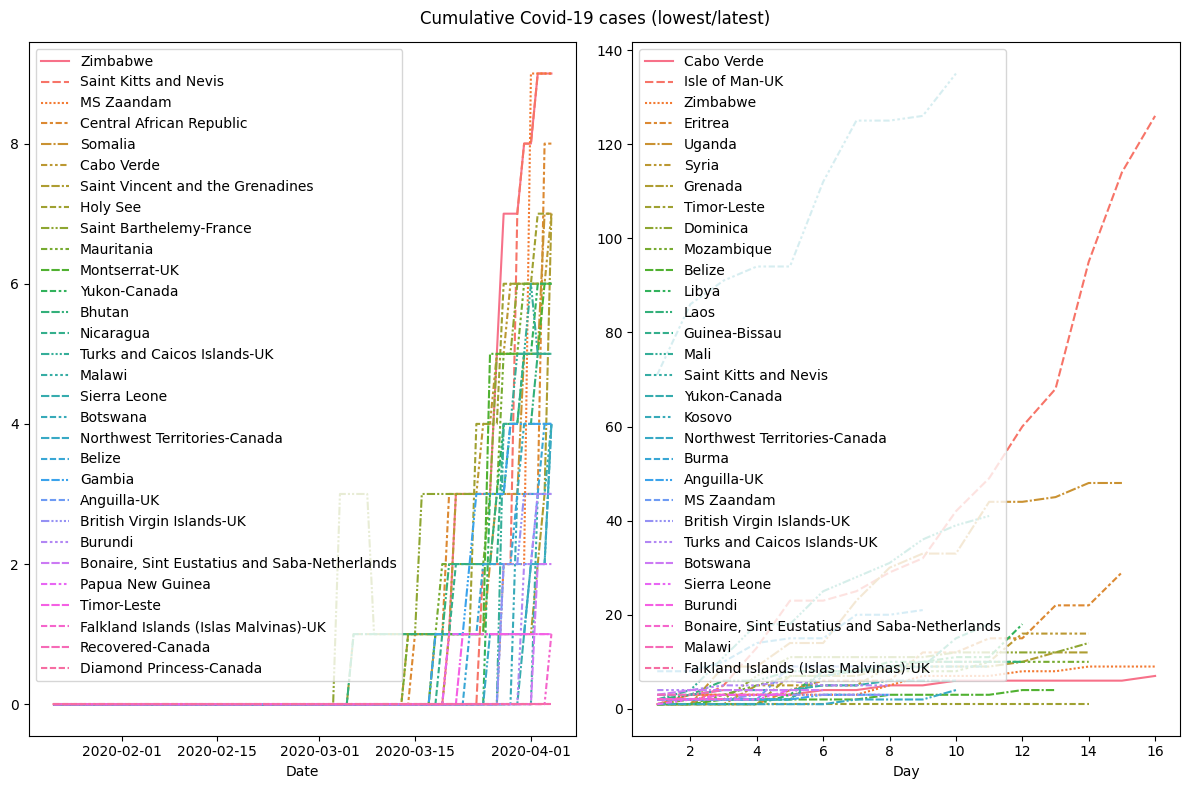

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.lineplot(data=data_1date_low, ax=ax1)
sns.lineplot(data=data_1day_low, ax=ax2)

fig.suptitle('Cumulative Covid-19 cases (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig1_low.png')

### Cases per 1 million

#### Highest and oldest cases

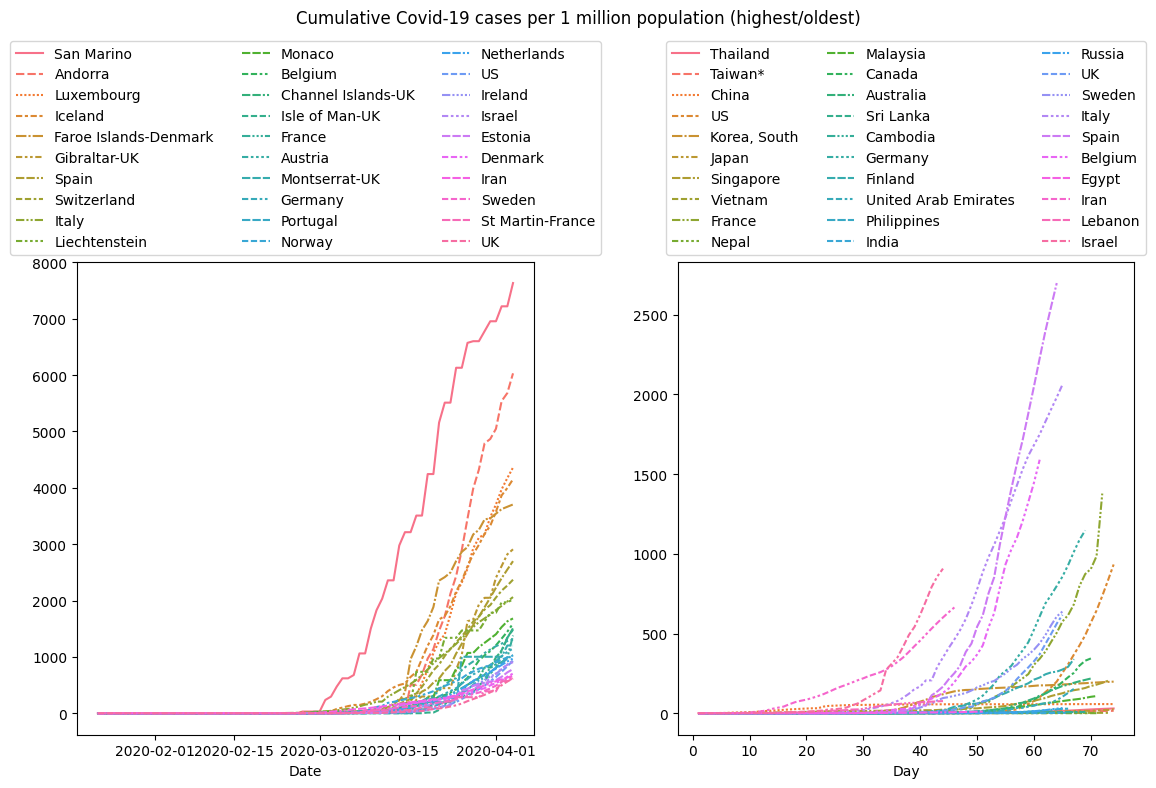

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.lineplot(data=data_2date_trunc, ax=ax1)
sns.lineplot(data=data_2day_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases per 1 million population (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig2_high.png')

#### Lowest and latest cases

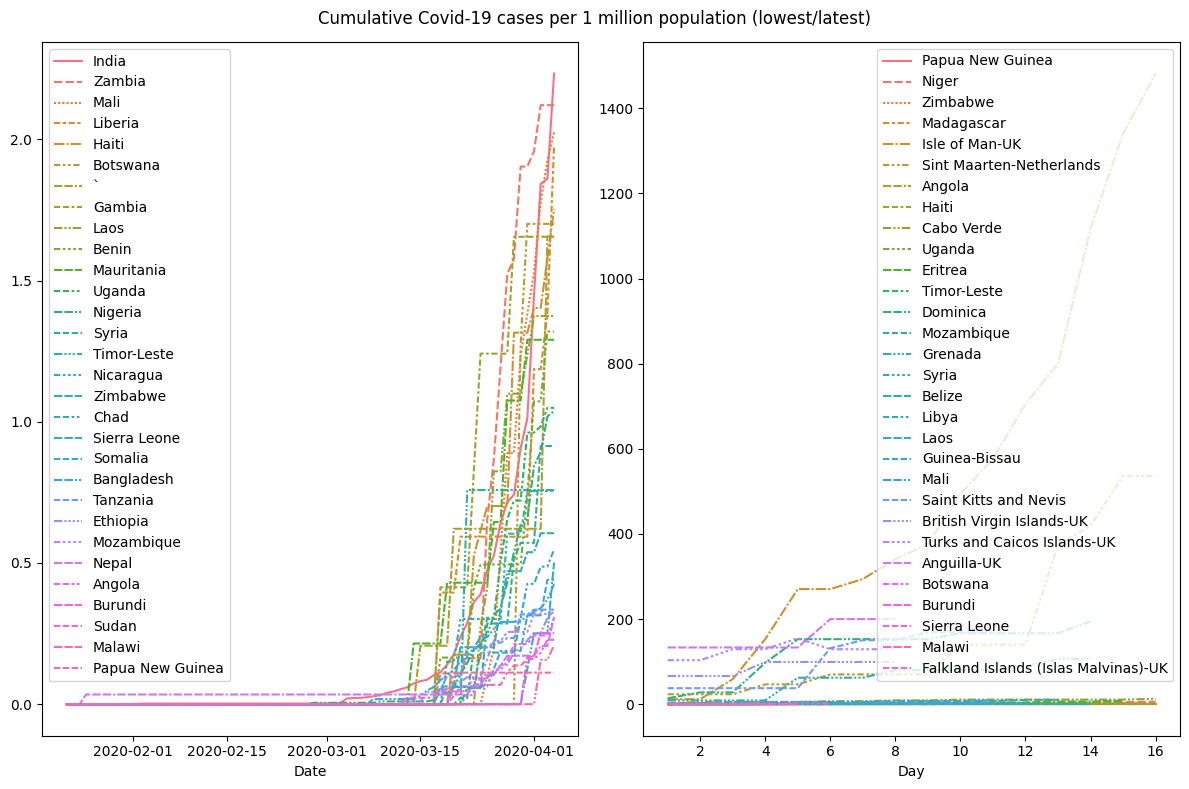

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.lineplot(data=data_2date_low, ax=ax1)
sns.lineplot(data=data_2day_low, ax=ax2)

fig.suptitle('Cumulative Covid-19 cases per 1 million population (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig2_low.png')

### Cases per population per land

#### Highest and oldest cases

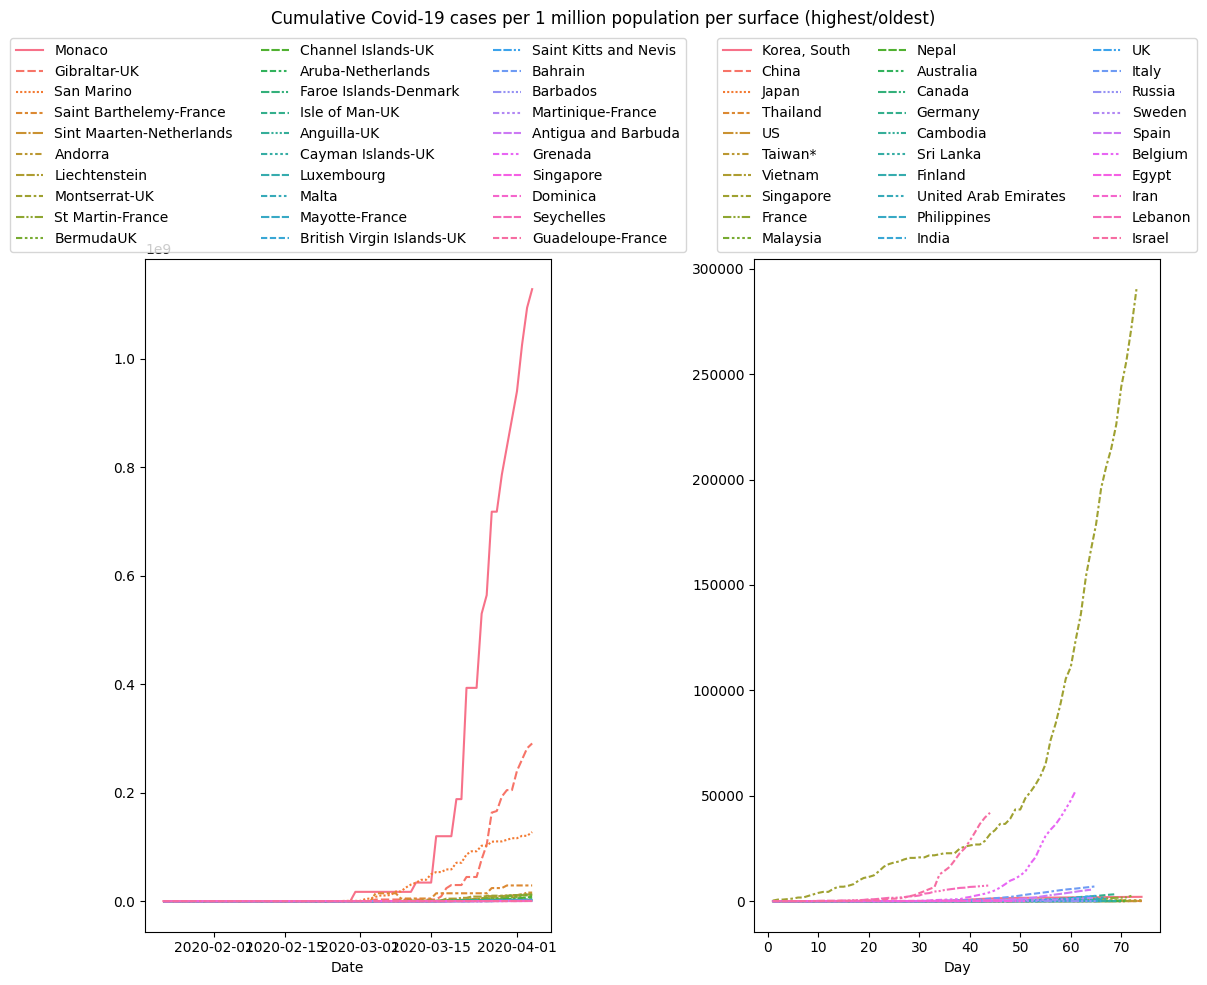

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_5date_trunc, ax=ax1)
sns.lineplot(data=data_5day_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases per 1 million population per surface (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig5_high.png')

#### Lowest and latest cases

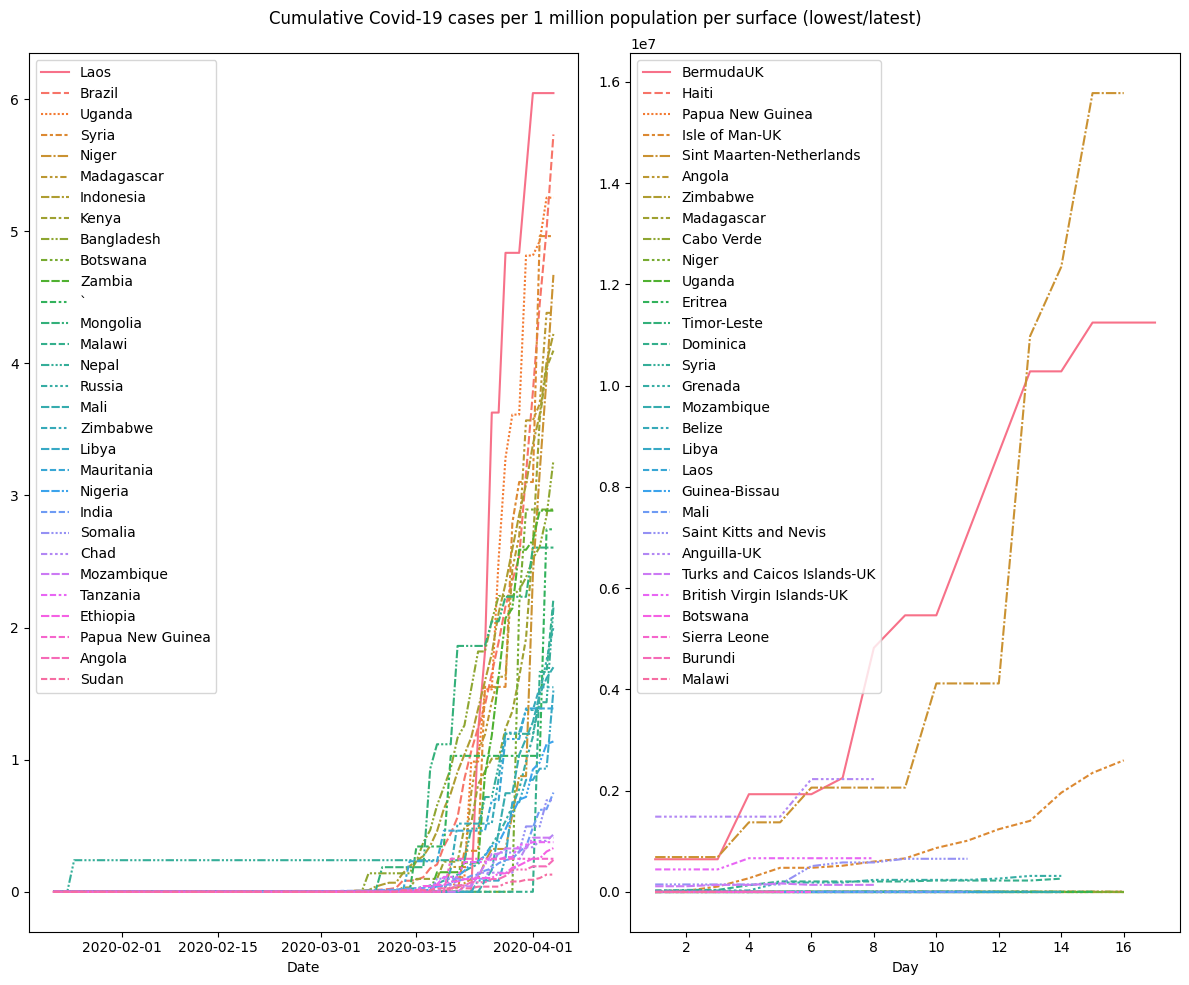

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_5date_low, ax=ax1)
sns.lineplot(data=data_5day_low, ax=ax2)

fig.suptitle('Cumulative Covid-19 cases per 1 million population per surface (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig5_low.png')

# Agglomerative Clustering

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [13]:
#TODO Check why there are differents in clustering for our clustering and the paper (e.g. Fig. 6 has San Marino separated, we not)
def plot_hierarchy(data, ax, complete=False):
    data = data.transpose()
    if not complete:
        linkage_matrix = linkage(data, method='single', metric='euclidean')
    else:
        linkage_matrix = linkage(data, method='complete', metric='euclidean')
    
    country_names = data.index.to_list()

    def llf(i):
        return '{}---{}'.format(country_names[i], i)

    R = dendrogram(
        linkage_matrix
        , ax=ax
        , orientation='right'
        , leaf_label_func=llf
        , count_sort=True
    )
    ax.set_xticks([])
    return R

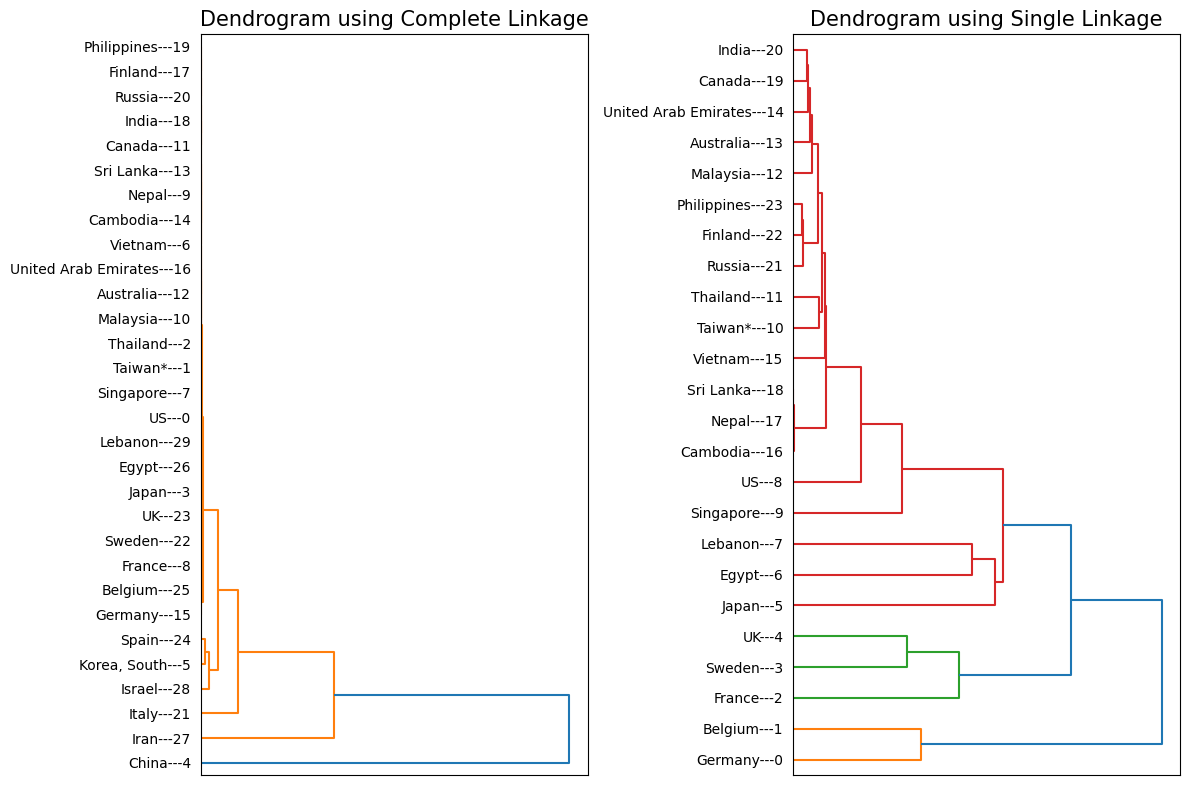

In [14]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

dend1 = plot_hierarchy(data_1day_trunc[:44], ax=axes[0], complete=True)
plot_hierarchy(data_1day_trunc.iloc[:44, dend1['leaves'][6:]], ax=axes[1])

axes[0].set_title('Dendrogram using Complete Linkage', fontsize=15)
axes[1].set_title('Dendrogram using Single Linkage', fontsize=15)

fig.tight_layout()

plt.savefig('../figures/Clustering1')

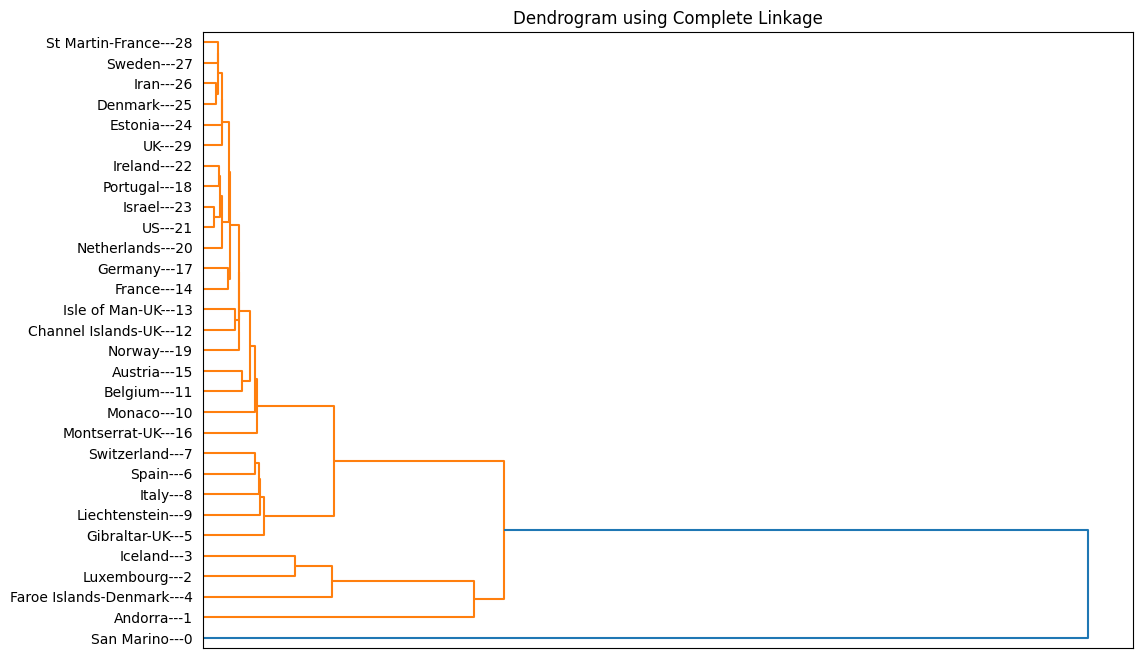

In [15]:
fig, axes = plt.subplots(figsize=(12, 8))

plot_hierarchy(data_2date_trunc, ax=axes)

axes.set_title('Dendrogram using Complete Linkage')

plt.savefig('../figures/Clustering2')

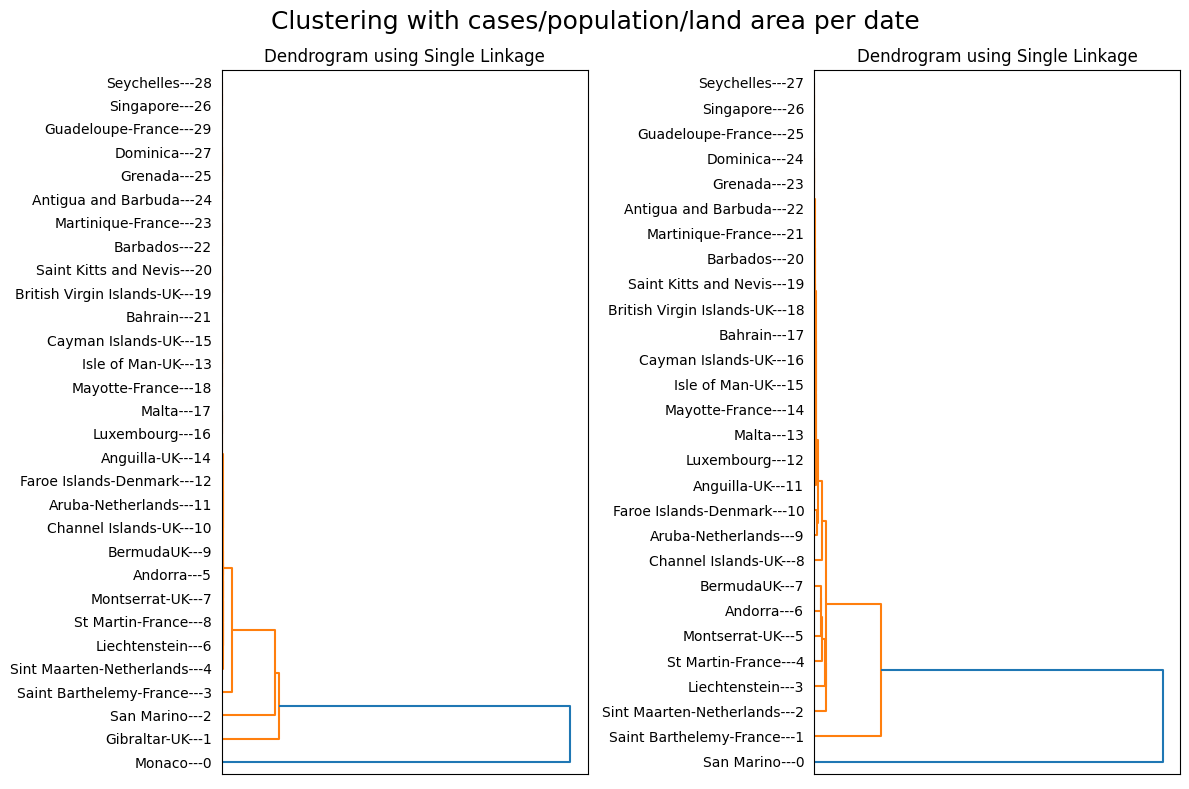

In [16]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

dend5 = plot_hierarchy(data_5date_trunc, ax=axes[0])
plot_hierarchy(data_5date_trunc.iloc[:, dend5['leaves'][2:]], ax=axes[1])

fig.suptitle('Clustering with cases/population/land area per date', fontsize=18)
axes[0].set_title('Dendrogram using Single Linkage')
axes[1].set_title('Dendrogram using Single Linkage')

fig.tight_layout()

plt.savefig('../figures/Clustering5')

# World map

In [31]:
num_clusters = 6
method = 'complete'
metric = 'euclidean'
data_world = data_1day_trunc[:44].T.copy()  
columns = list(set(data_1day.columns) & set(data_1date.columns)) 

In [38]:
matrix = linkage(data_world, method=method, metric=metric)
cluster_assignment = cut_tree(matrix, n_clusters=num_clusters) + 1
clusters = pd.DataFrame(cluster_assignment, index=data_world.index)
temp = pd.DataFrame([0] * len(columns), index=columns, columns=['clusters'])
temp.loc[clusters.index] = clusters 
clusters = temp.copy()

In [39]:
codes = []
for country in clusters.index:
    try:
        codes.append(countrynames.to_code_3(country))
    except:
        try: 
            codes.append(pycountry.countries.get(name=country).alpha_3)
        except: 
            codes.append(country)
codes = pd.DataFrame(codes, index=clusters.index, columns=['CODE'])
data_world_clusters = clusters.join(codes)


In [20]:
geolocator = Nominatim(user_agent='covid_data')
def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return (loc.latitude, loc.longitude)
    except:
        return np.nan

location_list = []
for country in codes.iloc[:, 0]:
    location_list.append(geolocate(country))

In [40]:
location_data = pd.DataFrame(location_list, index=data_world_clusters.index, columns=['latitude', 'longitude']) 
data_world_location = data_world_clusters.copy().join(location_data)

In [41]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
merge = pd.merge(world, data_world_location, on='CODE')

In [42]:
title = f'Cluster 30 countries into {num_clusters} subclusters'

chart = alt.Chart(merge, title=title).mark_geoshape().encode(
    color='clusters:N'
).project(
    'equirectangular'
).properties(
    width=800,
    height=400
)

chart.save('../figures/world_map.html')
chart

c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)